In [9]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
data = pl.read_excel('Data/CleanData.xlsx').select('Date', 'CUSIP', 'asset_type', 'credit_rating', 
                                                   'spread', (pl.col('spread') * pl.col('duration')).alias('DTS')).filter(pl.col('spread') != 0)

data = data.sort('Date', 'CUSIP').with_columns((pl.col('spread') - pl.col('spread').shift(1).over('CUSIP')).alias('abs_spread_chg'),
                                               ((pl.col('spread') - pl.col('spread').shift(1).over('CUSIP')) / pl.col('spread')).alias('pct_spread_chg')).drop_nulls().unique()
data = data.filter(pl.col('spread') < pl.col('spread').quantile(0.99), pl.col('spread') > pl.col('spread').quantile(0.01))
data = data.filter(pl.col('asset_type') == 'Credit')

Text(0.5, 1.0, 'Spread Change Volatility Over Time')

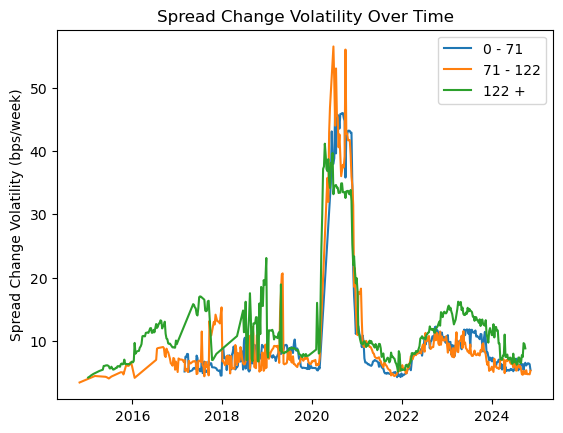

In [20]:
vols = data.sort('Date', 'CUSIP').with_columns(pl.col('abs_spread_chg').rolling_std(36).over('CUSIP').alias('abs_vol'),
                                               pl.col('pct_spread_chg').rolling_std(36).over('CUSIP').alias('pct_vol')).drop_nulls()
excess = vols.with_columns((pl.col('DTS') * pl.col('pct_vol')).alias('excess_return_vol'))
bucket1 = excess['spread'].quantile(0.33) # 71
bucket2 = excess['spread'].quantile(0.66) # 121

spread_buckets = excess.with_columns(pl.when(pl.col('spread') < bucket1)
                           .then(pl.lit('0'))
                        .otherwise(pl.when(pl.col('spread') < bucket2)
                           .then(pl.lit('1'))
                         .otherwise(pl.lit('2'))).alias('bucket'))

spread_buckets = spread_buckets.filter(pl.col('spread') >= 20)

grouped = spread_buckets.group_by('Date', 'bucket').agg(pl.col('abs_vol').mean(), pl.len(), pl.col('DTS').mean(), pl.col('excess_return_vol').mean()).sort('Date')
b0 = grouped.filter(pl.col('len') > 5, pl.col('bucket') == '0').sort('Date')
b1 = grouped.filter(pl.col('len') > 5, pl.col('bucket') == '1').sort('Date')
b2 = grouped.filter(pl.col('len') > 5, pl.col('bucket') == '2').sort('Date')

plt.figure()
plt.plot(b0['Date'], b0['abs_vol'], label = '0 - 71')
plt.plot(b1['Date'], b1['abs_vol'], label = '71 - 122')
plt.plot(b2['Date'], b2['abs_vol'], label = '122 +')
plt.legend()
plt.ylabel('Spread Change Volatility (bps/week)')
plt.title('Spread Change Volatility Over Time')

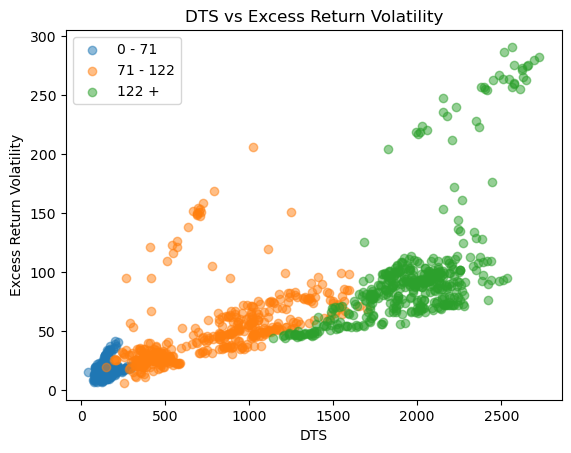

In [21]:
plt.scatter(b0['DTS'], b0['excess_return_vol'], alpha = 0.5, label = '0 - 71')
plt.scatter(b1['DTS'], b1['excess_return_vol'], alpha = 0.5, label = '71 - 122')
plt.scatter(b2['DTS'], b2['excess_return_vol'], alpha = 0.5, label = '122 +')
plt.xlabel('DTS')
plt.ylabel('Excess Return Volatility')
plt.title('DTS vs Excess Return Volatility')
plt.legend()

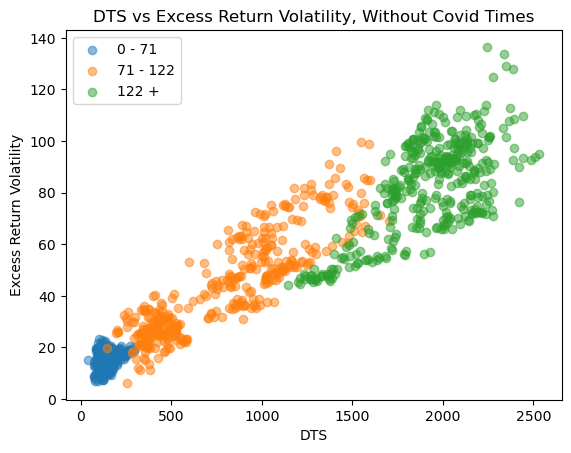

In [22]:
b0_filt = b0.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))
b1_filt = b1.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))
b2_filt = b2.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))

plt.scatter(b0_filt['DTS'], b0_filt['excess_return_vol'], alpha = 0.5, label = '0 - 71')
plt.scatter(b1_filt['DTS'], b1_filt['excess_return_vol'], alpha = 0.5, label = '71 - 122')
plt.scatter(b2_filt['DTS'], b2_filt['excess_return_vol'], alpha = 0.5, label = '122 +')
plt.xlabel('DTS')
plt.ylabel('Excess Return Volatility')
plt.title('DTS vs Excess Return Volatility, Without Covid Times')
plt.legend()